## Advanced Modelling of the Data

In [1]:
%load_ext autoreload
%autoreload 2

Flick this setting to switch between GPU and CPU processing

In [2]:
use_gpu=True

In [3]:
if use_gpu:
    import cudf as dd
    from cuml.preprocessing.model_selection import train_test_split
    from cuml.metrics import confusion_matrix, roc_auc_score
else:
    import pandas as dd
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, roc_auc_score

In [4]:
# first lets reload the dataset
# we do need to import pandas as it is also need for display max_rows 
import pandas as pd
import cudf
import numpy as np
import gc
import cupy
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# to avoid issues due to lack of VRAM
if use_gpu:
    cudf.set_allocator("managed")

## Read in the Features

Load the training set

In [6]:
%%time

## testing our previous big feats table
train = dd.read_parquet('data_eng/feats/train_feats.parquet')

## test is the kaggle test set which we only need for submission 
#test = dd.read_parquet('data_eng/feats/test_feats.parquet')
train_target = train['TARGET']
train = train.drop('TARGET', axis =1)

In [7]:
train.shape

(307511, 638)

In [8]:
# we have an unbalanced pos to negative ratio so it will help to feed this into xgb
ratio = (train_target == 0).sum()/ (train_target == 1).sum()
ratio

11.387150050352467

## Cross Validating our XGB Model

Default train test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train, train_target, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [10]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

We use stratified KFold as the classes are heavily unbalanced. Stratified KFold makes sure that we have a same proportion of target variables (0/1) in each kfold split 

In [11]:
skf = StratifiedKFold()

In [12]:
cv_params = {'tree_method': 'gpu_hist', 'max_depth': 6, 
             'learning_rate': 0.05, 'subsample':0.5, 
             'objective': 'binary:logistic',
             'eval_metric':'auc', 'scale_pos_weight': ratio,
             'gamma':0.3, 'subsample':0.5}

if use_gpu:
    cv_params['tree_method'] = 'gpu_hist'
else:
    cv_params['tree_method'] = 'hist'


We use stratified KFold to check and see if different splits of the data produce consistant results. This is important to make sure we aren't overfitting to a particular subset of data

In [13]:
if use_gpu:
    x_train_index = X_train.index.to_arrow().tolist()
    y_train_index = y_train.to_arrow().tolist()
else:
    x_train_index = X_train.index
    y_train_index = y_train


In [14]:
%%time

for i, (train_index, test_index) in enumerate(skf.split(x_train_index, y_train_index)):
    
    print("Fold {0}".format(i))
    X_train_kf, X_valid_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_valid_kf = y_train.iloc[train_index], y_train.iloc[test_index]
    
    train_matrix_kf= xgb.DMatrix(X_train_kf, label=y_train_kf)
    val_matrix_kf = xgb.DMatrix(X_valid_kf, label=y_valid_kf)
    
    bst = xgb.train(params=cv_params, dtrain=train_matrix_kf, 
                evals=[(train_matrix_kf, 'train'), (val_matrix_kf, 'valid')], 
                num_boost_round=100, early_stopping_rounds=20, verbose_eval=20)

Fold 0
[0]	train-auc:0.73129	valid-auc:0.72169
[20]	train-auc:0.77468	valid-auc:0.75784
[40]	train-auc:0.79182	valid-auc:0.76661
[60]	train-auc:0.80668	valid-auc:0.77290
[80]	train-auc:0.81825	valid-auc:0.77734
[99]	train-auc:0.82692	valid-auc:0.77978
Fold 1
[0]	train-auc:0.73264	valid-auc:0.71298
[20]	train-auc:0.77718	valid-auc:0.74850
[40]	train-auc:0.79346	valid-auc:0.75633
[60]	train-auc:0.80911	valid-auc:0.76357
[80]	train-auc:0.82015	valid-auc:0.76817
[99]	train-auc:0.82896	valid-auc:0.77129
Fold 2
[0]	train-auc:0.73385	valid-auc:0.71466
[20]	train-auc:0.77847	valid-auc:0.74802
[40]	train-auc:0.79562	valid-auc:0.75654
[60]	train-auc:0.81022	valid-auc:0.76358
[80]	train-auc:0.82165	valid-auc:0.76777
[99]	train-auc:0.83049	valid-auc:0.77023
Fold 3
[0]	train-auc:0.73207	valid-auc:0.71610
[20]	train-auc:0.77714	valid-auc:0.75127
[40]	train-auc:0.79393	valid-auc:0.76201
[60]	train-auc:0.80870	valid-auc:0.76805
[80]	train-auc:0.81998	valid-auc:0.77161
[99]	train-auc:0.82884	valid-auc:

In [15]:
del X_train_kf, X_valid_kf
gc.collect()

224

In [ ]:
del bst, train_matrix_kf, val_matrix_kf
gc.collect()

Once things look a bit stable with the tuning, we will train our "final" model on the full dataset

In [16]:
full_cv_params =  cv_params
# a common technique is to set learning rate lower and 
# boost the num_boost_rounds for the full train
full_cv_params['learning_rate'] = cv_params['learning_rate']/10

In [17]:
%%time

train_matrix = xgb.DMatrix(X_train, label=y_train)
val_matrix = xgb.DMatrix(X_test, label=y_test)
    
final_bst = xgb.train(params=full_cv_params, dtrain=train_matrix, 
                evals=[(train_matrix, 'train'), (val_matrix, 'valid')], 
                num_boost_round=1000, early_stopping_rounds=20, 
                verbose_eval=50)

[0]	train-auc:0.73118	valid-auc:0.71839
[50]	train-auc:0.76236	valid-auc:0.74581
[100]	train-auc:0.76647	valid-auc:0.74860
[150]	train-auc:0.77028	valid-auc:0.75096
[200]	train-auc:0.77423	valid-auc:0.75318
[250]	train-auc:0.77815	valid-auc:0.75554
[300]	train-auc:0.78210	valid-auc:0.75780
[350]	train-auc:0.78592	valid-auc:0.75986
[400]	train-auc:0.78982	valid-auc:0.76206
[450]	train-auc:0.79360	valid-auc:0.76414
[500]	train-auc:0.79727	valid-auc:0.76616
[550]	train-auc:0.80084	valid-auc:0.76807
[600]	train-auc:0.80417	valid-auc:0.76961
[650]	train-auc:0.80712	valid-auc:0.77105
[700]	train-auc:0.80991	valid-auc:0.77217
[750]	train-auc:0.81246	valid-auc:0.77324
[800]	train-auc:0.81491	valid-auc:0.77423
[850]	train-auc:0.81729	valid-auc:0.77514
[900]	train-auc:0.81946	valid-auc:0.77592
[950]	train-auc:0.82167	valid-auc:0.77664
[999]	train-auc:0.82368	valid-auc:0.77723


In [18]:
adv_y_pred = final_bst.predict(val_matrix)
# convert to 0/1 based on threshold
adv_y_final = np.where(adv_y_pred>0.5, 1, 0)

# Final Assessments

In [19]:
confusion_matrix(y_test, adv_y_final.astype('Int64'))

<ipython-input-19-3f2062bd99d2>:1: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  confusion_matrix(y_test, adv_y_final.astype('Int64'))


array([[62583, 22258],
       [ 2419,  4994]])

In [20]:
roc_auc_score(y_test, adv_y_pred)

0.7772647754597993

## Evaluating Feature Importances

Evaluating the importance of features using SHAP values

In [21]:
if use_gpu:
    pred_gpu = 'gpu_predictor'
else:
    pred_gpu = 'cpu_predictor'

In [22]:
final_bst.set_param({"predictor": pred_gpu})
shap_values = final_bst.predict(val_matrix, pred_contribs=True)

In [23]:
%%time 

# We can use the shap package
import shap

# shap will call the GPU accelerated version as long as the predictor 
# parameter is set to "gpu_predictor"
final_bst.set_param({"predictor": pred_gpu})
explainer = shap.TreeExplainer(final_bst)
shap_values = explainer.shap_values(X_test)

Choose which data entry to inspect here

In [24]:
entry_to_inspect=0

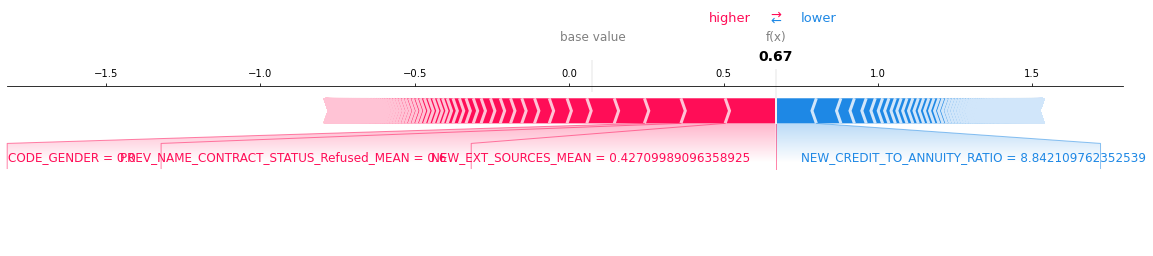

In [25]:
if use_gpu:
    feature_set = cupy.asnumpy(X_test.iloc[entry_to_inspect].values)
else:
    feature_set = X_test.iloc[entry_to_inspect]
    
# visualize the first prediction's explanation
shap.force_plot(
    explainer.expected_value,
    shap_values[entry_to_inspect, :],
    feature_set,
    feature_names=X_test.columns.to_list(),
    matplotlib=True
)

This SHAP force chart allows us to see which variable is the most important for the end result

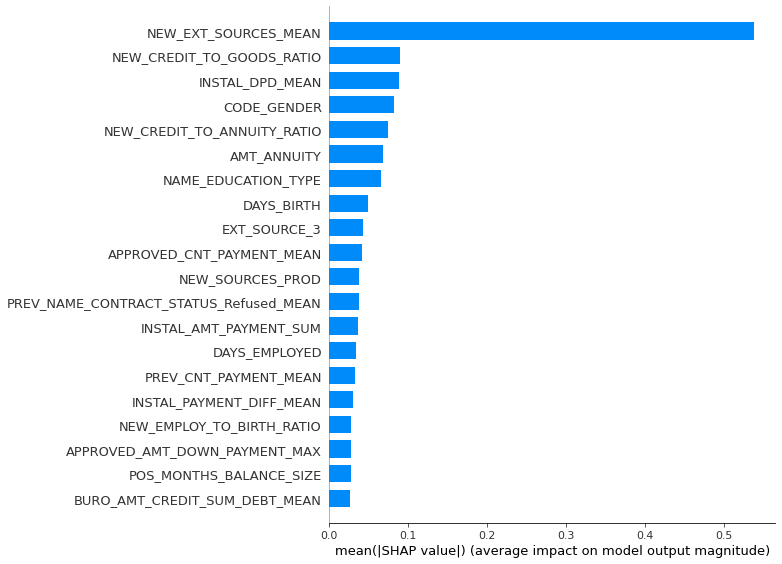

In [26]:
# Show a summary of feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", 
                  feature_names=X_test.columns)